### Rasters for a single spikeglx session
- Load an exctractor for visualization of the data
- Load the sorts as in notebook sglx_pipe-dev-sort-rasters--z_w12m7_20-20201104
- load the mot_dict
- plot rasters
- export to npy for brad

### SGL spikeextractor needs spikeextractors==0.9.3, spikeinterface==0.12.0. 
Will break with other versions.
TODO: make sure my spikeglxrecordingextractor works with newer spikeextractors or get rid of it and adapt theirs.
(the why i did my own is because theirs had an obscure way of reading the digital channels in the nidaqs).

In [19]:
%matplotlib inline

import os
import glob
import logging
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import pickle

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
from ceciestunepipe.file import filestructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-08-27 13:52:03,131 root         INFO     all modules loaded


In [5]:
reload(et)

sess_par = {'bird': 'z_w12m7_20',
           'sess': '20201104',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['raw']

sess_epochs = sglu.list_sgl_epochs(sess_par)
sess_epochs

2021-08-27 13:52:36,670 ceciestunepipe.util.sglxutil INFO     {'folders': {'bird': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20', 'raw': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104', 'kwik': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104', 'processed': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104', 'derived': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/derived/20201104', 'tmp': '/scratch/earneodo/tmp/tmp', 'msort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/msort/20201104', 'ksort': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104'}, 'files': {'par': '/scratch/earneodo/tmp/z_w12m7_20/Ephys/ksort/20201104/params.json', 'set': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/settings.isf', 'rig': '/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/raw/20201104/rig.json', 'kwd': '/mnt/sphere/earneodo/bci_zf/ss_data/z_w12m7_20/Ephys/kwik/20201104/stream.

['20201104_alles',
 '2500r250a_3500_dir_g0',
 '2500r250a_3500_dir_g1',
 '2500r250a_3500_dir_g2']

In [7]:
### pick a session
reload(et)
reload(sglu)
epoch = sess_epochs[1] # g2 is the shortest

exp_struct = sglu.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['raw'])
files_pd = pd.DataFrame(sgl_files)

### get the recordings just in case

In [9]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}


### load the sort and the motif dictionary

In [8]:
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
plt.rcParams['lines.linewidth'] = 0.1

axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

###### load sort

In [20]:
spike_pickle_path = os.path.join(exp_struct['folders']['processed'], 'spk_df.pkl')
clu_pickle_path = os.path.join(exp_struct['folders']['processed'], 'clu_df.pkl')

spk_df = pd.read_pickle(spike_pickle_path)
clu_df = pd.read_pickle(clu_pickle_path)

##### load motif dictionary

In [18]:
mot_dict_path = os.path.join(exp_struct['folders']['processed'], 'mot_dict.pkl')
logger.info('Loading mot_dict from {}'.format(mot_dict_path))

with open(mot_dict_path, 'rb') as handle:
    mot_dict = pickle.load(handle)

mot_dict

2021-08-27 14:23:39,729 root         INFO     Loading mot_dict from /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/mot_dict.pkl


{'template': memmap([ 1650,  1551,   631, ..., -1943, -1825, -1245], dtype=int16),
 's_f': 25000,
 's_f_nidq': 24999.666666666668,
 's_f_ap_0': 30000.0,
 'start_ms': array([  12830.17106895,   13350.17800237,   13872.18496247,
          14710.19613595,   15556.2074161 ,   16436.21914959,
        7315281.53708716, 7316353.55138068, 7317229.56306084,
        7318138.575181  ]),
 'start_sample_naive': array([   320750,    333750,    346800,    367750,    388900,    410900,
        182879600, 182906400, 182928300, 182951025]),
 'start_sample_nidq': array([   320751,    333751,    346801,    367751,    388901,    410901,
        182879601, 182906401, 182928301, 182951026]),
 'start_t_0': array([  12.83021107,   13.350218  ,   13.87222496,   14.71023614,
          15.55624742,   16.43625915, 7315.28157709, 7316.35359138,
        7317.22960306, 7318.13861518]),
 'start_t_ap_0': array([  12.83021251,   13.35023873,   13.87221502,   14.71021434,
          15.55626437,   16.43627212, 7315.266995

#####  make a raster

In [29]:
## the start times synched to the spike time base (ap_0, comes from sglx_pipe-dev-sort-rasters notebook)
mot_samples = mot_dict['start_sample_ap_0']
mot_s_f = mot_dict['s_f']
ap_s_f = mot_dict['s_f_ap_0']

In [30]:
mot_samples

array([   384907,    400508,    416167,    441307,    466689,    493089,
       219458073, 219490233, 219516513, 219543782])

In [31]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)

##### collect all good, ra units

In [34]:
t_pre = - 0.5
t_post = 1.5
t_pre_samp = int(t_pre * ap_s_f)
t_post_samp = int(t_post * ap_s_f)

In [35]:
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])



In [36]:
rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

2021-08-27 14:43:52,784 numexpr.utils INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-08-27 14:43:52,784 numexpr.utils INFO     Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-08-27 14:43:52,785 numexpr.utils INFO     NumExpr defaulting to 8 threads.
2021-08-27 14:43:52,785 numexpr.utils INFO     NumExpr defaulting to 8 threads.


In [37]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

spk_arr = get_window_spikes(spk_df, clu_list, int(ap_start + pre_sec*ap_sf), int(ap_start + post_sec*ap_sf))

fig, ax = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), nidq_sf)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*ap_sf), ax=ax[1])
plt.tight_layout()

NameError: name 'ap_start' is not defined

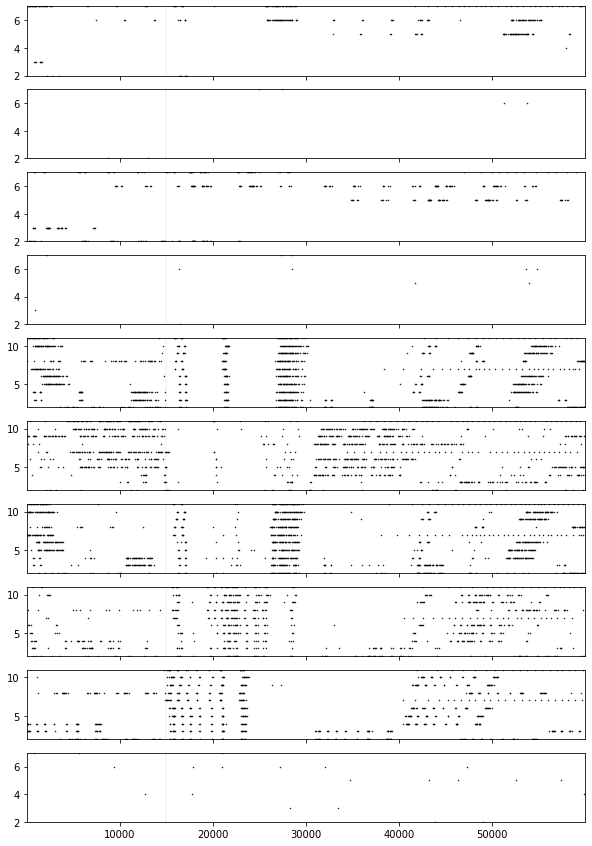

In [38]:
fig, ax_arr = plt.subplots(nrows=10, figsize=[10, 15], sharex=True)

for i_rast, clu_idx in enumerate(range(20, 30)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])

##### export to npy arrays

In [102]:
def export_spikes_array(spk_df, clu_list, start_samples, span_samples, file_path, bin_size=None):
    # get the raster for the clu_list
    # if necessary, bin it
    # save it as numpy
    rast_arr = get_rasters(spk_df, clu_list, start_samples, span_samples)
    
    if bin_size:
        logger.info('Getting binned spikes with {} sample bins'.format(bin_size))
        rate_arr = pu.coarse(np.transpose(rast_arr, axes=[0, 2, 1]), n_coarse=bin_size)
        # switch back axes to [clu, t, trial]
        export_arr = np.transpose(rate_arr, axes=[0, 2, 1])
        #export_arr = rate_arr
    else:
        export_arr = rast_arr
    
    logger.info('saving spikes as {}'.format(file_path))
    np.save(file_path, export_arr)
    return export_arr



In [ ]:
rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

In [130]:
mot_len = mot_dict['template'].size
mot_len_s = mot_len / mot_s_f
t_pre = - 0.5
t_post = 0.5 + mot_len_s
bin_ms = 0

t_pre_samp = int(t_pre * ap_s_f)
t_post_samp = int(t_post * ap_s_f)
bin_samp = int(bin_ms * ap_s_f * 0.001)

spk_arr_list = []
for nucleus in ['hvc', 'ra']:
    # get the cluster list
    clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin([nucleus])), 
                                'cluster_id'])
    # make the file path
    file_path = os.path.join(exp_struct['folders']['processed'], 
                             'fr_arr-{}-{}ms.pkl'.format(nucleus, bin_ms))
    logger.info('saving spikes as {}'.format(file_path))
    
    # get the spikes to the file
    spk_arr = export_spikes_array(spk_df, 
                                  clu_list, 
                                  mot_dict['start_sample_ap_0'] + t_pre_samp, 
                                  t_post_samp - t_pre_samp, 
                                  file_path, 
                                  bin_samp)
    spk_arr_list.append(spk_arr)

2021-08-27 16:26:54,973 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/fr_arr-hvc-0ms.pkl
2021-08-27 16:26:54,973 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/fr_arr-hvc-0ms.pkl
2021-08-27 16:26:58,612 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/fr_arr-hvc-0ms.pkl
2021-08-27 16:26:58,612 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/fr_arr-hvc-0ms.pkl
2021-08-27 16:26:59,373 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/fr_arr-ra-0ms.pkl
2021-08-27 16:26:59,373 root         INFO     saving spikes as /mnt/cube/earneodo/bci_zf/neuropi

In [131]:
spk_arr.shape

(145, 46498, 10)

#### plot one spk_arr together with a motif

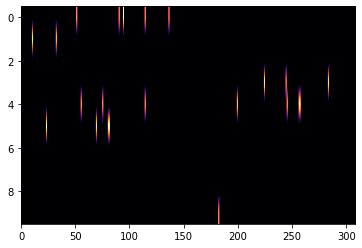

In [129]:
spk_arr = spk_arr_list[1]
plt.imshow(spk_arr[32, :, :].T, aspect='auto', cmap='inferno')

In [101]:
np.transpose(spk_arr, axes=[0, 2, 1]).shape

(145, 774, 10)

In [ ]:
plt.plot(spk_arr[0].sum(axis=1))

In [57]:
np.transpose(rast_arr, axes=[0, 2, 1]).shape

(145, 10, 60000)

In [79]:
spk_arr.shape

(145, 46498, 10)

In [84]:
mot_len = mot_dict['template'].size
mot_len_s = mot_len / mot_s_f
t_pre = - 0.5
t_post = 0.5 + mot_len_s
bin_ms = 2

t_pre_samp = int(t_pre * ap_s_f)
t_post_samp = int(t_post * ap_s_f)
bin_samp = int(bin_ms * ap_s_f * 0.001)

In [112]:
mot_len_s

0.54996

In [85]:
fr_arr = pu.coarse(np.transpose(rast_arr, axes=[0, 2, 1]), n_coarse=bin_samp)
fr_arr.shape

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


(145, 10, 1000)

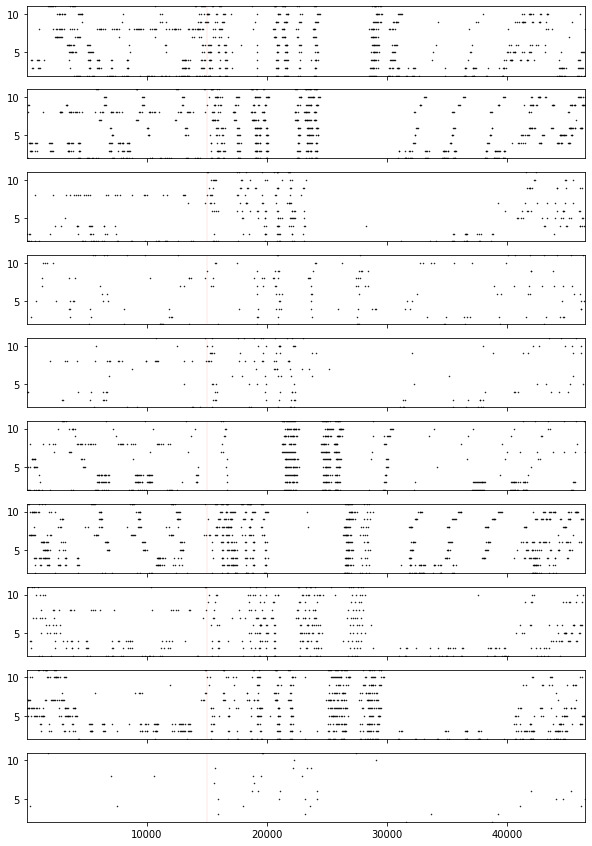

In [134]:
fig, ax_arr = plt.subplots(nrows=10, figsize=[10, 15], sharex=True)

for i_rast, clu_idx in enumerate(range(50, 60)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    plot_as_raster(spk_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])